### ISTA can effectively reconstruct sparse signal from noisy measurements, and converges realtively quick

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Sparse signal generation

In [2]:
# A,x: gaussian mean 0, variance 1
A=np.random.randn(2000,1000) 
x=np.random.randn(1000,1) 

#sparsify x
zero_indices = np.random.choice(np.arange(1000),replace=False,size=int(900)) #900 random indices
x[zero_indices]=0 #x is 100-sparse

# e: gaussian mean 0, variance 0.1
e=np.random.normal(0, np.sqrt(0.1) , size=(2000,1))

y= A@x + e

### τ_λ(x) = sign(x) * max(|x| - λ, 0), soft thresholding operator, used for sparse signal reconstruction
--- 
* If |x| ≤ λ: Output is 0
* If x > λ: Output is x - λ
* If x < -λ: Output is x + λ

---
* Shrinks values toward zero by λ amount
* Sets values with magnitude less than λ to exactly zero
* Preserves the sign of the input

---
* It promotes sparsity by setting small coefficients to zero
* It's a key step in solving l1-regularized optimization problems
* In ISTA, it helps find sparse solutions by iteratively applying soft-thresholding

---

In [4]:
def g(x,lamda):
    return 0.5*np.linalg.norm(A@x-y)**2+lamda*np.linalg.norm(x,1)

#derivative of function f
def delta_f(x):
    return A.T@(A@x-y)

#Soft Thresholding Operator
def STO(x,lamda,alpha):
    c=lamda*alpha
    x[(x>=-c)&(x<=c)]=0
    x[x<-c]+=c
    x[x>c]-=c
    return x

### ITERATIVE SOFT-THRESHOLDING ALGORITHM

In [10]:
max_iterations=100
alpha=0.0001 #step size
lamda=5     #lambda
g_k=[]

#initialize x: x_0=0
x_k=np.zeros((1000,1))

for _ in tqdm(range(max_iterations)):
    x_k-=alpha*delta_f(x_k) #step update for f(x)
    x_k=STO(x_k,lamda,alpha) #soft thresholding
    
    g_k.append(g(x_k,lamda))

print('The obtained solution is '+str(len(x_k[x_k!=0]))+'-sparse')  

100%|██████████| 100/100 [00:00<00:00, 274.08it/s]

The obtained solution is 717-sparse


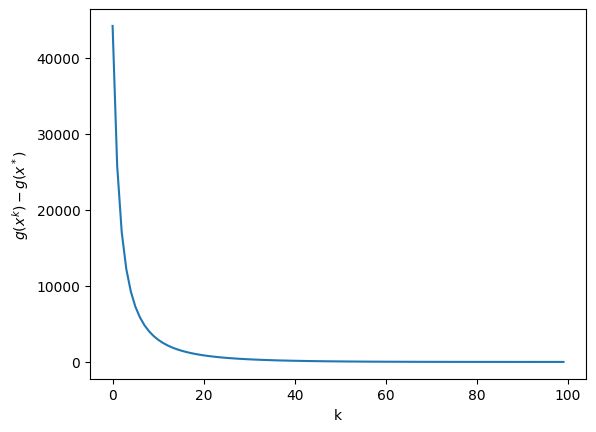

In [11]:
plt.xlabel('k')
plt.ylabel('$g(x^k) - g(x^*)$')
plt.plot(g_k-g_k[-1])

In [9]:
print('MSE:', np.linalg.norm(x_k-x)**2/np.linalg.norm(x)**2)

MSE: 0.0007910255320821668


In [12]:
# A,x: gaussian mean 0, variance 1
A=np.random.randn(500,2000)
x=np.random.randn(2000,1) 

#Range of k and lambda values
k_iterations=np.arange(0,501,50) 
k_iterations[0]=1
lambda_iterations= np.geomspace(0.001, 1000, 20) #logarithmic scale

max_iterations=100
alpha=0.0001 #step size
mse=[]


for k in tqdm(k_iterations):
    x_star=np.copy(x)
    zero_indices = np.random.choice(np.arange(2000),replace=False,size=int(2000-k)) #2000-k random indices
    x_star[zero_indices]=0 #x is k-sparse
    y= A@x_star
    
    temp_mse=[]
    for lamda in lambda_iterations:
        
        x_k=np.zeros((2000,1)) #initialize x: x_0=0
        #ISTA
        for _ in range(max_iterations):
            x_k-=alpha*delta_f(x_k) #step update for f(x)
            x_k=STO(x_k,lamda,alpha) #soft thresholding

        temp_mse.append(np.linalg.norm(x_k-x_star)**2/np.linalg.norm(x_star)**2) 
    
    #store lowest error
    mse.append(np.min(temp_mse))
        

100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


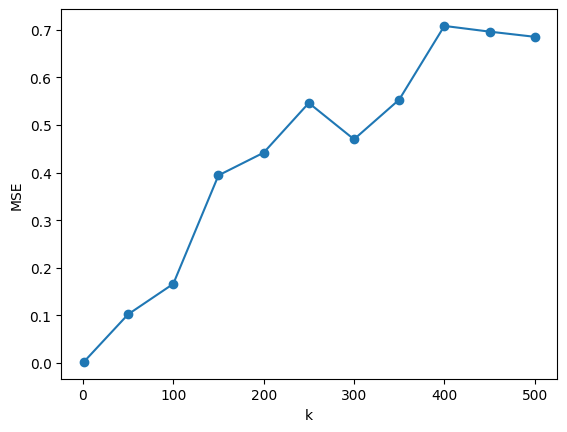

In [13]:
plt.xlabel('k')
plt.ylabel('MSE')
k=k_iterations
plt.plot(k,mse,marker="o")